In [4]:
pip install tensorflow


Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [44]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import nltk
import re

In [45]:
# Specify the filename
input_file = 'holmes.txt'

# Read the contents of the file
with open(input_file, 'r', encoding='utf-8') as infile:
    data = infile.read()

In [46]:
data[:100] # view first few characters

"*Project Gutenberg's Etext of Tom Swift And His Submarine Boat*\n\n#4 in the Victor Appleton's Tom Swi"

In [47]:

# Limit data to 500000 characters
data = data[:700000]

In [50]:
# Function to remove emojis and special characters from text
def remove_emojis_and_special_characters(text):
    # Remove emojis
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F700-\U0001F77F"  # alchemical symbols
                               u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                               u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                               u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                               u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                               u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                               u"\U00002702-\U000027B0"  # Dingbats
                               u"\U000024C2-\U0001F251" 
                               "]+", flags=re.UNICODE)
    
    # Remove special characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    
    # Remove extra spaces
    text = re.sub(' +', ' ', text)
    
    return text

In [49]:
# Preprocessing pipeline
def preprocess_pipeline(data) -> 'list':
    # Split by newline character
    sentences = data.split('\n')
    for i in range(len(sentences)):
        sentences[i] = remove_emojis_and_special_characters(sentences[i])
    # Remove leading and trailing spaces
    sentences = [s.strip() for s in sentences]
    # Drop empty sentences
    sentences = [s for s in sentences if len(s) > 0]
    # Tokenization
    tokenized = []
    for sentence in sentences:
        # Convert to lowercase
        sentence = sentence.lower()
        tokenized.append(sentence)
    return tokenized

# Tokenize sentences
tokenized_sentences = preprocess_pipeline(data)

In [51]:
"""
What is an OOV Token?
An out-of-vocabulary (OOV) token is a special token used in natural language processing (NLP) tasks to represent words that
are not present in the vocabulary of the model or tokenizer. When a word that is not in the vocabulary is encountered during
tokenization or text processing, it is replaced with the OOV token.

Why Use an OOV Token?
Using an OOV token helps handle unseen or unknown words during the training or inference phase of an NLP model. 
Instead of encountering errors or issues when encountering unknown words, the model can gracefully handle them by
representing them with the OOV token. This is particularly useful when working with real-world data where the vocabulary
of the model may not cover all possible words.
"""
# Tokenize words
tokenizer = Tokenizer(oov_token='<oov>')
tokenizer.fit_on_texts(tokenized_sentences)
total_words = len(tokenizer.word_index) + 1
# tokenizer.word_counts
# tokenizer.word_index
"""
n_gram example:
[3, 15, 8, 7, 20, 12, 6]

For the above sentece sentence, the code would generate the following n-gram sequences:

[3, 15]
[3, 15, 8]
[3, 15, 8, 7]
[3, 15, 8, 7, 20]
[3, 15, 8, 7, 20, 12]
[3, 15, 8, 7, 20, 12, 6]
"""

# Generate input sequences
input_sequences = []
for line in tokenized_sentences:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i + 1]
        input_sequences.append(n_gram_sequence)

# Pad sequences
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

In [52]:
# Creates labels with input sequences
X,labels = input_sequences[:,:-1],input_sequences[:,-1]
ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [53]:
# Split data into training, validation, and test sets
from sklearn.model_selection import train_test_split
X_train_temp, X_val_test, y_train_temp, y_val_test = train_test_split(X, ys, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)


Train LSTM Model

In [54]:
# Define your model
model = Sequential()
model.add(Embedding(total_words, 100)) 
model.add(Bidirectional(LSTM(150)))
model.add(Dense(total_words, activation='softmax'))

adam = Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

# Train the model
history = model.fit(X_train_temp, y_train_temp, epochs=10, validation_data=(X_val, y_val), verbose=1)

Epoch 1/10
2774/2774 ━━━━━━━━━━━━━━━━━━━━ 145s 50ms/step - accuracy: 0.0962 - loss: 6.3720 - val_accuracy: 0.1398 - val_loss: 5.7560
Epoch 2/10
2774/2774 ━━━━━━━━━━━━━━━━━━━━ 130s 47ms/step - accuracy: 0.1497 - loss: 5.2880 - val_accuracy: 0.1479 - val_loss: 5.7691
Epoch 3/10
2774/2774 ━━━━━━━━━━━━━━━━━━━━ 137s 49ms/step - accuracy: 0.1704 - loss: 4.8023 - val_accuracy: 0.1520 - val_loss: 5.9188
Epoch 4/10
2774/2774 ━━━━━━━━━━━━━━━━━━━━ 134s 48ms/step - accuracy: 0.1887 - loss: 4.4669 - val_accuracy: 0.1547 - val_loss: 6.1550
Epoch 5/10
2774/2774 ━━━━━━━━━━━━━━━━━━━━ 132s 48ms/step - accuracy: 0.1979 - loss: 4.2418 - val_accuracy: 0.1587 - val_loss: 6.4486
Epoch 6/10
2774/2774 ━━━━━━━━━━━━━━━━━━━━ 134s 48ms/step - accuracy: 0.2101 - loss: 4.1746 - val_accuracy: 0.1581 - val_loss: 6.7024
Epoch 7/10
2774/2774 ━━━━━━━━━━━━━━━━━━━━ 120s 43ms/step - accuracy: 0.2199 - loss: 4.0152 - val_accuracy: 0.1510 - val_loss: 6.9681
Epoch 8/10
2774/2774 ━━━━━━━━━━━━━━━━━━━━ 131s 47ms/step - accuracy: 

Save Models (Weights and biases)

In [55]:
# Save model architecture as JSON file
from tensorflow.keras.models import model_from_json

model_json = model.to_json()
with open("lstm_model.json", "w") as json_file:
    json_file.write(model_json)

In [56]:
# Load model architecture from JSON file
from tensorflow.keras.models import model_from_json

with open("lstm_model.json", "r") as json_file:
    loaded_model_json = json_file.read()

# # Create model from loaded architecture
loaded_model = model_from_json(loaded_model_json)

print("Model architecture loaded successfully from JSON file.")


# 7. Save your trained model  <--- THIS IS THE KEY STEP
model.save('my_language_model.h5')  # Save it to a file!

Model architecture loaded successfully from JSON file.


In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

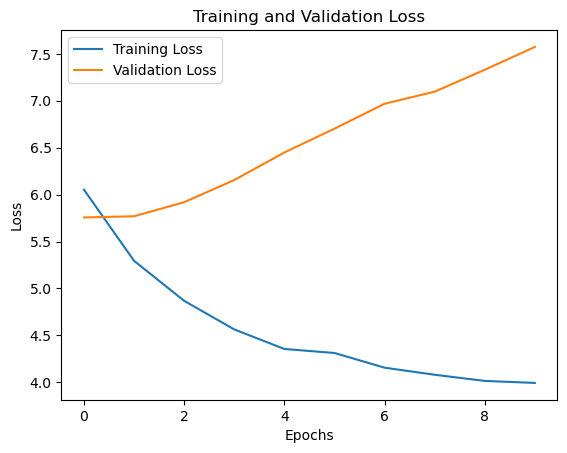

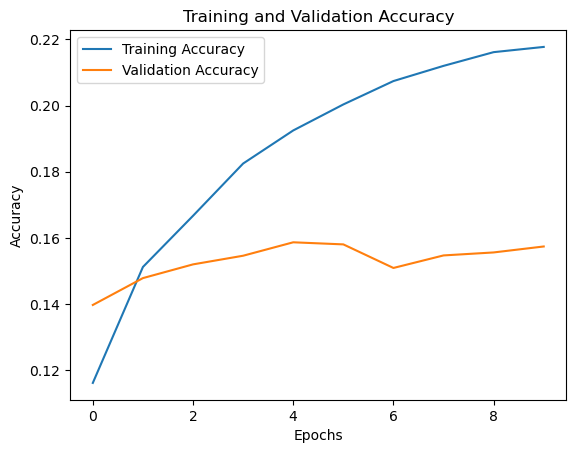

In [58]:
# Plot Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [59]:
import pickle
tokenizer_file_path = r"C:\Users\nkavi\OneDrive\Desktop\play~tts\tokenizer.pickle"
try:
    
    pickle.dump(tokenizer,open(tokenizer_file_path,'wb'))
    print(f"Tokenizer successfully saved to: {tokenizer_file_path}")  # Confirm success
except Exception as e:
    print(f"Error saving tokenizer: {e}")  # Print any error message
    # Handle the error (e.g., exit, raise an exception)

Tokenizer successfully saved to: C:\Users\nkavi\OneDrive\Desktop\play~tts\tokenizer.pickle


In [ ]:
'''if not os.path.exists(tokenizer_file_path):
    raise FileNotFoundError(f"Tokenizer file not found at: {tokenizer_file_path}")
with open(tokenizer_file_path, 'rb') as handle:
    tokenizer = pickle.load(handle)
print(f"pickle.load returned: {tokenizer}") # Debug
if tokenizer is None:
    print("ERROR: pickle.load returned None!")'''

pickle.load returned: None
ERROR: pickle.load returned None!


code to make the tokenizer and loading the model

In [60]:
from tensorflow.keras.models import model_from_json, load_model
import pickle

# --- Load model weights and other components if architecture loaded successfully ---
if loaded_model is not None:
    try:
        # Load the model weights from the .h5 file
        loaded_model.load_weights('my_language_model.h5')  # Load the weights into the loaded model
        # Load the tokenizer
        tokenizer_file_path = r'C:\Users\nkavi\OneDrive\Desktop\play~tts\tokenizer.pickle'
        print(f"Attempting to load tokenizer from: {tokenizer_file_path}")  # Debug
        if not os.path.exists(tokenizer_file_path):
            raise FileNotFoundError(f"Tokenizer file not found at: {tokenizer_file_path}")
        with open(tokenizer_file_path, 'rb') as handle:
            tokenizer = pickle.load(handle)
        print(f"pickle.load returned: {tokenizer}") # Debug
        if tokenizer is None:
            print("ERROR: pickle.load returned None!") #IMPORTANT
     
        max_sequence_len = 25
        print("Model architecture, weights, and tokenizer loaded successfully.")
    except Exception as e:
        print(f"Error loading model weights or tokenizer: {e}")
        # Optionally, you could set loaded_model = None here if loading weights fails
        #  depending on how you want your program to handle this scenario.
        tokenizer = None
        max_sequence_len = None
else:
  tokenizer = None
  max_sequence_len = None
print(f"Tokenizer: {tokenizer}")
print(f"Max Sequence Length: {max_sequence_len}")

Attempting to load tokenizer from: C:\Users\nkavi\OneDrive\Desktop\play~tts\tokenizer.pickle
pickle.load returned: <keras.src.legacy.preprocessing.text.Tokenizer object at 0x000001A5BDA8BFE0>
Model architecture, weights, and tokenizer loaded successfully.
Tokenizer: <keras.src.legacy.preprocessing.text.Tokenizer object at 0x000001A5BDA8BFE0>
Max Sequence Length: 25


Inferences

In [61]:
def predict_top_five_words(model, tokenizer, seed_text):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = model.predict(token_list, verbose=0)
    top_five_indexes = np.argsort(predicted[0])[::-1][:5]
    top_five_words = []
    for index in top_five_indexes:
        for word, idx in tokenizer.word_index.items():
            if idx == index:
                top_five_words.append(word)
                break
    return top_five_words

from IPython.display import HTML

def predict_top_five_words(model, tokenizer, seed_text):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = model.predict(token_list, verbose=0)
    top_five_indexes = np.argsort(predicted[0])[::-1][:5]
    top_five_words = []
    for index in top_five_indexes:
        for word, idx in tokenizer.word_index.items():
            if idx == index:
                top_five_words.append(word)
                break
    return top_five_words

def predict_and_display_top_five_words(seed_text, model, tokenizer):
    top_five_words = predict_top_five_words(model, tokenizer, seed_text)
    heading_app = f"<h1>Sentence AutoCompletion App With Five Outputs</h1>"
    output_text = f"<ul>{''.join([f'<li>{seed_text} {word}</li>' for word in top_five_words])}</ul>"
    javascript_code = f"""
    <script>
        var newWindow = window.open("", "_blank");
        newWindow.document.write('<html><head><title>Top Five Words</title></head><body>{heading_app} <br> <hr> {output_text}</body></html>');
    </script>
    """
    return HTML(javascript_code)

In [80]:
import tkinter as tk
from tkinter import ttk
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import pickle
import os
from tkinter import Tk, scrolledtext, Button, Frame,Toplevel, END, INSERT

try:
    # --- Load your trained model and tokenizer ---
    model = load_model('my_language_model.h5')  # replace with your actual model file
    with open('tokenizer.pickle', 'rb') as handle:
       tokenizer = pickle.load(handle)
    max_sequence_len = 25  # replace with the actual value used during training
except ImportError:
    print("Error: TensorFlow and/or pickle are not installed. Please install them to run this application.")
    model = None
    tokenizer = None
    max_sequence_len = 0
except FileNotFoundError:
    print("Error: Model or tokenizer file not found. Please ensure the paths are correct.")
    model = None
    tokenizer = None
    max_sequence_len = 0 
# --- old Prediction Function ---
def predict_top_five_words(model, tokenizer, seed_text, max_sequence_len):
    print(f"predict_top_five_words called with seed_text: '{seed_text}'")
    if model is None:
        print("ERROR: Model is None in predict_top_five_words!")
        return []  # Important: Return an empty list if model is None
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = model.predict(token_list, verbose=0)
    top_five_indexes = np.argsort(predicted[0])[::-1][:5]
    top_five_words = []
    for index in top_five_indexes:
        for word, idx in tokenizer.word_index.items():
            if idx == index:
                top_five_words.append(word)
                break
    print(f"top_five_words: {top_five_words}")
    return top_five_words

def show_predictions(event=None):
    if model is None or tokenizer is None:
        return

    current_text = text_area.get("1.0", tk.END).strip()
    if not current_text:
        hide_predictions()
        return

    cursor_index = text_area.index(tk.INSERT)
    line, char = map(int,cursor_index.split('.'))
    prefix_text = text_area.get(f"{line}.0", cursor_index).strip()

    if prefix_text:
        top_words = predict_top_five_words(model, tokenizer, prefix_text, max_sequence_len)
        display_floating_predictions(top_words, cursor_index)
    else:
        hide_predictions()


def add_word(word):
    cursor_index_before_insert = text_area.index(tk.INSERT)
    text_area.insert(cursor_index_before_insert, f" {word}")

    # Calculate the new cursor position
    line, char = map(int, cursor_index_before_insert.split('.'))
    new_char = char + len(word) + 1
    text_area.mark_set(tk.INSERT, f"{line}.{new_char}")
    text_area.see(tk.INSERT)  # Ensure the inserted text is visible

    window.after(100, show_predictions) # Delay prediction update
    hide_predictions() # Hide the floating window after selection

floating_predictions_window = None

def display_floating_predictions(words, cursor_index):
    global floating_predictions_window

    hide_predictions() # Hide any existing prediction window

    if words:
        floating_predictions_window = Toplevel(window)
        floating_predictions_window.transient(window) # Make it dependent on the main window
        # floating_predictions_window.grab_set() # Temporarily remove grab_set

        # Get cursor coordinates
        x, y, _, _ = text_area.bbox(cursor_index)
        text_x, text_y = text_area.winfo_rootx(), text_area.winfo_rooty()
        prediction_x = text_x + x
        prediction_y = text_y + y + 20 # Adjust vertical position

        floating_predictions_window.geometry(f"+{prediction_x}+{prediction_y}")
        floating_predictions_window.overrideredirect(True) # Remove window decorations

        for i, word in enumerate(words):
            button = Button(floating_predictions_window, text=word, command=lambda w=word: add_word(w))
            button.pack(side="left", padx=2, pady=2)

        floating_predictions_window.deiconify() # Ensure the window is visible
        floating_predictions_window.lift() # Bring it to the front

def hide_predictions(event=None):
    global floating_predictions_window
    if floating_predictions_window:
        floating_predictions_window.destroy()
        floating_predictions_window = None

# --- Main Application ---
window = tk.Tk()
window.title("Text Autocompletion")

text_area = scrolledtext.ScrolledText(window, height=10, width=50)
text_area.grid(row=0, column=0, padx=10, pady=10, sticky="nsew")
window.grid_columnconfigure(0, weight=1)
window.grid_rowconfigure(0, weight=1)

# Bind text input event to show predictions
text_area.bind("<KeyRelease>", show_predictions)
text_area.bind("<Button-1>", show_predictions) # Update predictions on mouse click (cursor change)
text_area.bind("<FocusOut>", hide_predictions) # Hide predictions when focus leaves the text area

# Initial call to display predictions (in case there's initial text)
show_predictions()

window.mainloop()



predict_top_five_words called with seed_text: 'h'
top_five_words: ['interest', 'the', 'and', 'jest', 'complexion']
predict_top_five_words called with seed_text: 'hi'
top_five_words: ['interest', 'the', 'and', 'jest', 'complexion']
predict_top_five_words called with seed_text: 'hi'
top_five_words: ['interest', 'the', 'and', 'jest', 'complexion']
predict_top_five_words called with seed_text: 'hi b'
top_five_words: ['interest', 'the', 'complexion', 'jest', 'shadowy']
predict_top_five_words called with seed_text: 'hi ba'
top_five_words: ['interest', 'the', 'complexion', 'jest', 'shadowy']
predict_top_five_words called with seed_text: 'hi bab'
top_five_words: ['interest', 'the', 'complexion', 'jest', 'shadowy']
predict_top_five_words called with seed_text: 'hi baby'
top_five_words: ['and', 'as', 'no', 'was', 'in']
predict_top_five_words called with seed_text: 'hi baby'
top_five_words: ['and', 'as', 'no', 'was', 'in']
predict_top_five_words called with seed_text: 'hi baby  was'
top_five_word

KeyboardInterrupt: 

In [81]:
# Test the function
seed_text = "She is my"
if 'loaded_model' in globals() and 'tokenizer' in globals():  # check if loaded
    predictions = predict_top_five_words(loaded_model, tokenizer, seed_text, max_sequence_len)
    print(f"\nPredictions for '{seed_text}':")
    for sentence in predictions:
        print(sentence)
    else:
        print("\nModel and tokenizer not loaded.  Cannot run test.")


predict_top_five_words called with seed_text: 'She is my'
top_five_words: ['own', 'patchwork', 'firm', 'name', 'wife']

Predictions for 'She is my':
own
patchwork
firm
name
wife

Model and tokenizer not loaded.  Cannot run test.
